## Residual Networks

Welcome to the second assignment of this week! You will learn how to build very deep convolutional networks, using Residual Networks (ResNets). In theory, very deep networks can represent very complex functions; but in practice, they are hard to train. Residual Networks, introduced by [He et al](https://arxiv.org/pdf/1512.03385.pdf)., allow you to train much deeper networks than were previously practically feasible.



<b>In this assignment, you will:</b>

- Implement the basic building blocks of ResNets.
- Put together these building blocks to implement and train a state-of-the-art neural network for image classification.

This assignment will be done in Keras.

Before jumping into the problem, let's run the cell below to load the required packages.

In [ ]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow

from test_utils import summary, comparator
import public_tests

%matplotlib inline

## <b>1 - The Problem of Very Deep Neural Networks</b>

Last week, you built your first convolutional neural networks: first manually with numpy, then using Tensorflow and Keras. 

In recent years, neural networks have become much deeper, with state-of-the-art networks evolving from having just a few layers (e.g., AlexNet) to over a hundred layers.

* The main benefit of a very deep network is that it can represent very complex functions. It can also learn features at many different levels of abstraction, from edges (at the shallower layers, closer to the input) to very complex features (at the deeper layers, closer to the output). 

* However, using a deeper network doesn't always help. A huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent prohibitively slow.

* More specifically, during gradient descent, as you backpropagate from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode," from gaining very large values). 

* During training, you might therefore see the magnitude (or norm) of the gradient for the shallower layers decrease to zero very rapidly as training proceeds, as shown below: 

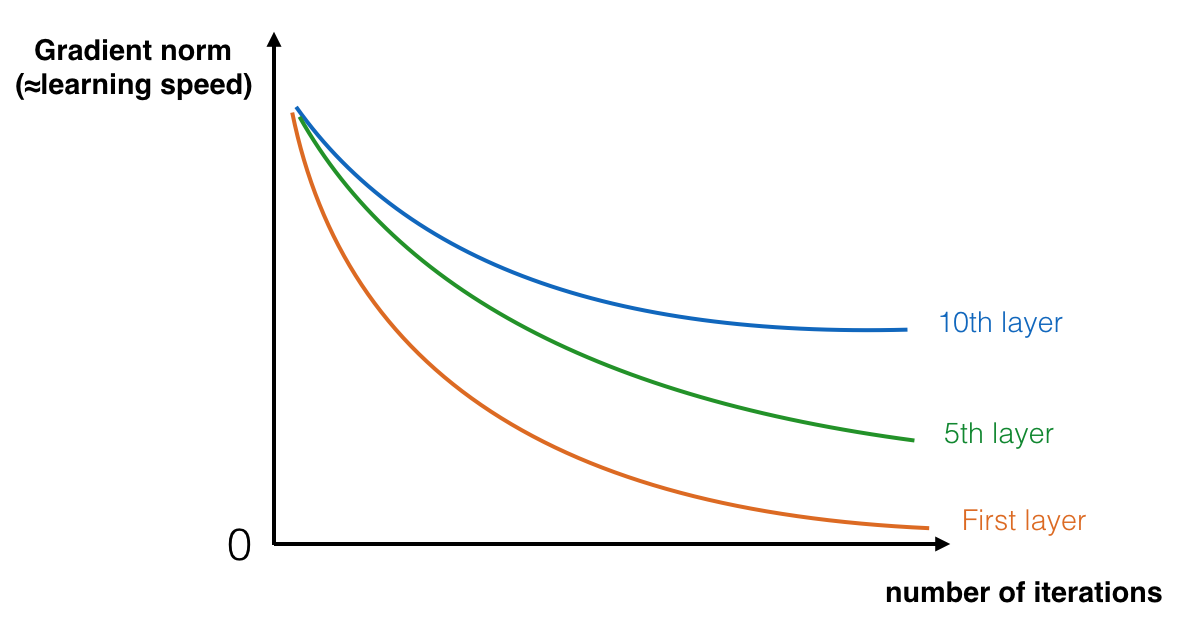

## <b>2 - Building a Residual Network</b>

In ResNets, a "shortcut" or a "skip connection" allows the model to skip layers:  

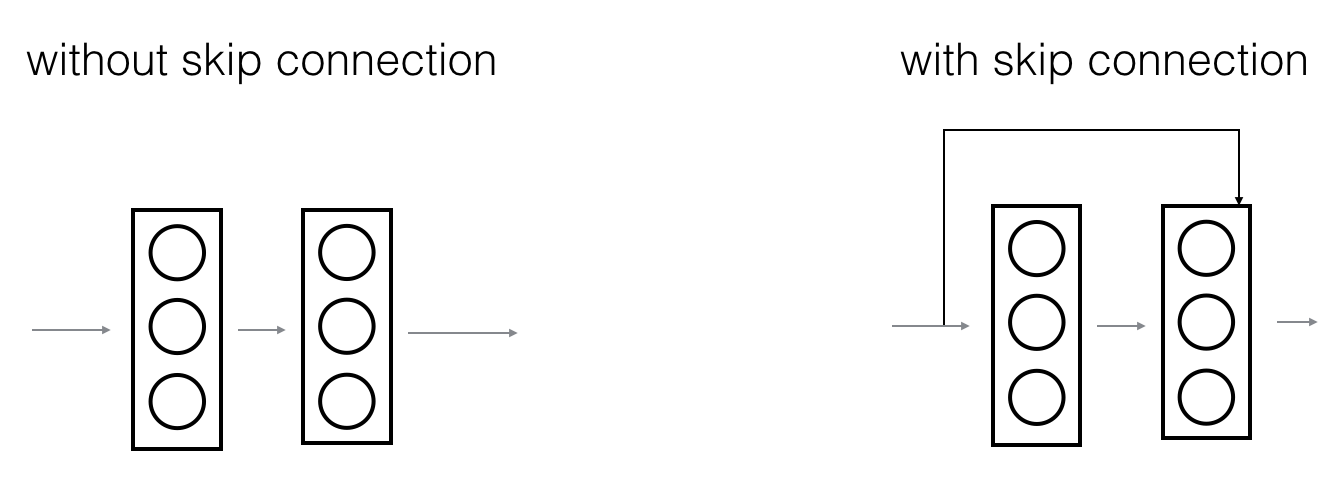

The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, you can form a very deep network. 

The lecture mentioned that having ResNet blocks with the shortcut also makes it very easy for one of the blocks to learn an identity function. This means that you can stack on additional ResNet blocks with little risk of harming training set performance.  
    
On that note, there is also some evidence that the ease of learning an identity function accounts for ResNets' remarkable performance even more than skip connections help with vanishing gradients.

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are the same or different. You are going to implement both of them: the "identity block" and the "convolutional block."

### <b>2.1 - The Identity Block</b>

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:

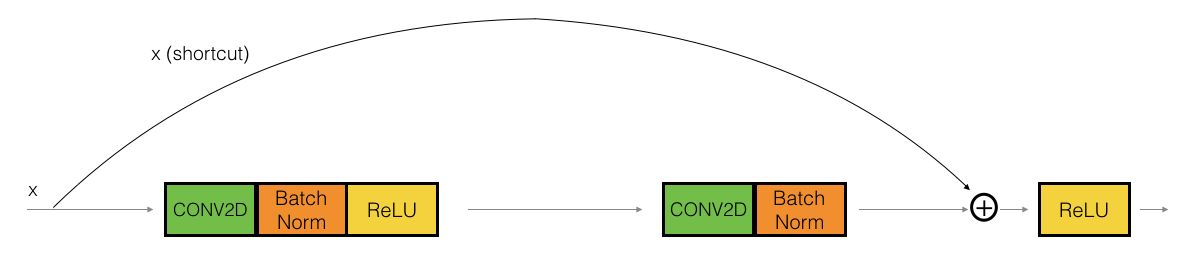

The upper path is the "shortcut path." The lower path is the "main path." In this diagram, notice the CONV2D and ReLU steps in each layer. To speed up training, a BatchNorm step has been added. Don't worry about this being complicated to implement--you'll see that BatchNorm is just one line of code in Keras! 

In this exercise, you'll actually implement a slightly more powerful version of this identity block, in which the skip connection "skips over" 3 hidden layers rather than 2 layers. It looks like this: 

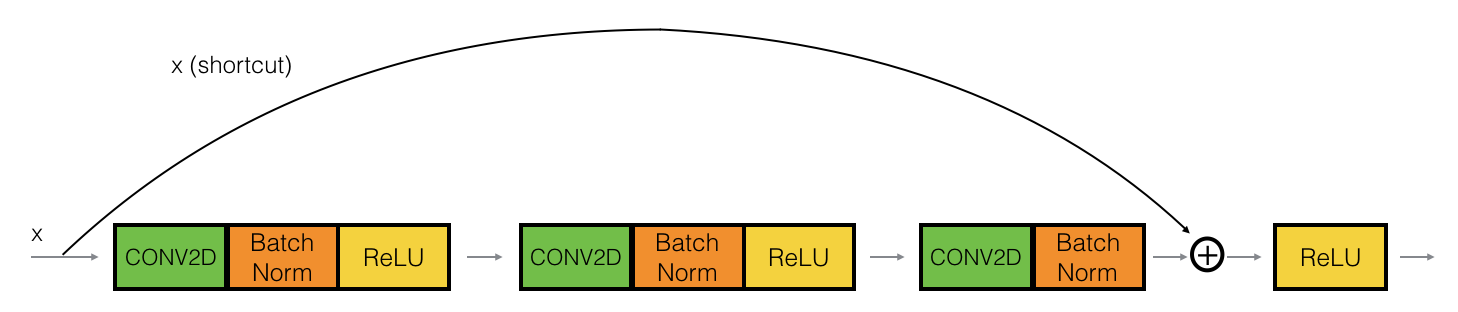

These are the individual steps:

First component of main path: 
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random uniform initialization: `kernel_initializer = initializer(seed=0)`. 
- The first BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Its padding is "same". Use 0 as the seed for the random uniform initialization: `kernel_initializer = initializer(seed=0)`.
- The second BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters.

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random uniform initialization: `kernel_initializer = initializer(seed=0)`. 
- The third BatchNorm is normalizing the 'channels' axis.
- Note that there is **no** ReLU activation function in this component. 

Final step: 
- The `X_shortcut` and the output from the 3rd layer `X` are added together.
- **Hint**: The syntax will look something like `Add()([var1,var2])`
- Then apply the ReLU activation function. This has no hyperparameters. 

<b> Exercise 1 - identity_block </b>

Implement the ResNet identity block. The first component of the main path has been implemented for you already! First, you should read these docs carefully to make sure you understand what's happening. Then, implement the rest. 
- To implement the Conv2D step: [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
- To implement BatchNorm: [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) `BatchNormalization(axis = 3)(X, training = training)`. If training is set to False, its weights are not updated with the new examples. I.e when the model is used in prediction mode.
- For the activation, use:  `Activation('relu')(X)`
- To add the value passed forward by the shortcut: [Add](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add)

We have added the initializer argument to our functions. This parameter receives an initializer function like the ones included in the package [tensorflow.keras.initializers](https://www.tensorflow.org/api_docs/python/tf/keras/initializers) or any other custom initializer. By default it will be set to [random_uniform](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/RandomUniform)

Remember that these functions accept a `seed` argument that can be any value you want, but that in this notebook must set to 0 for **grading purposes**.

In [ ]:
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    ### END CODE HERE ###

    return X

In [ ]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = identity_block(A_prev, f=2, filters=[2, 4, 6], stage=1, block='a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [ 0.94822985  0.          1.16101444  2.747859    0.          1.36677003]

<b>Expected Output:</b>

out = [ 0.94822985  0.          1.16101444  2.747859    0.          1.36677003]

### <b> 2.2 - The Convolutional Block </b>

The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path: 

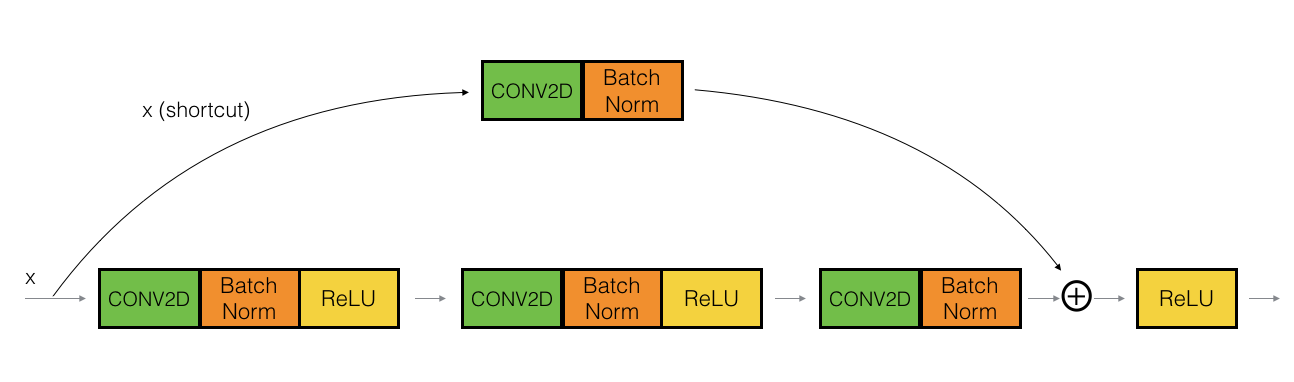

* The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. (This plays a similar role as the matrix $W_s$ discussed in lecture.) 
* For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. 
* The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. 
* As for the previous exercise, the additional `initializer` argument is required for grading purposes, and it has been set by default to [glorot_uniform](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform)

The details of the convolutional block are as follows. 

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid". Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The first BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape (f,f) and a stride of (1,1). Its padding is "same".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The second BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The third BatchNorm is normalizing the 'channels' axis. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The BatchNorm is normalizing the 'channels' axis. 

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no hyperparameters. 
 
<b> Exercise 2 - Convolutional_block </b>
    
Implement the convolutional block. The first component of the main path is already implemented; then it's your turn to implement the rest! As before, always use 0 as the seed for the random initialization, to ensure consistency with the grader.
- [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
- [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) (axis: Integer, the axis that should be normalized (typically the features axis)) `BatchNormalization(axis = 3)(X, training = training)`. If training is set to False, its weights are not updated with the new examples. I.e when the model is used in prediction mode.
- For the activation, use:  `Activation('relu')(X)`
- [Add](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add)
    
We have added the initializer argument to our functions. This parameter receives an initializer function like the ones included in the package [tensorflow.keras.initializers](https://www.tensorflow.org/api_docs/python/tf/keras/initializers) or any other custom initializer. By default it will be set to [random_uniform](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/RandomUniform)

Remember that these functions accept a `seed` argument that can be any value you want, but that in this notebook must set to 0 for **grading purposes**.

In [ ]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ### START CODE HERE
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training) 
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)
    
    ### END CODE HERE

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [ ]:
from outputs import convolutional_block_output1, convolutional_block_output2
np.random.seed(1)
#X = np.random.randn(3, 4, 4, 6).astype(np.float32)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A = convolutional_block(X, f = 2, filters = [2, 4, 6], training=False)

assert type(A) == EagerTensor, "Use only tensorflow and keras functions"
assert tuple(tf.shape(A).numpy()) == (3, 2, 2, 6), "Wrong shape."
assert np.allclose(A.numpy(), convolutional_block_output1), "Wrong values when training=False."
print(A[0])

B = convolutional_block(X, f = 2, filters = [2, 4, 6], training=True)
assert np.allclose(B.numpy(), convolutional_block_output2), "Wrong values when training=True."

print('\033[92mAll tests passed!')

##<b> 3 - Building Your First ResNet Model (50 layers) </b>

You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

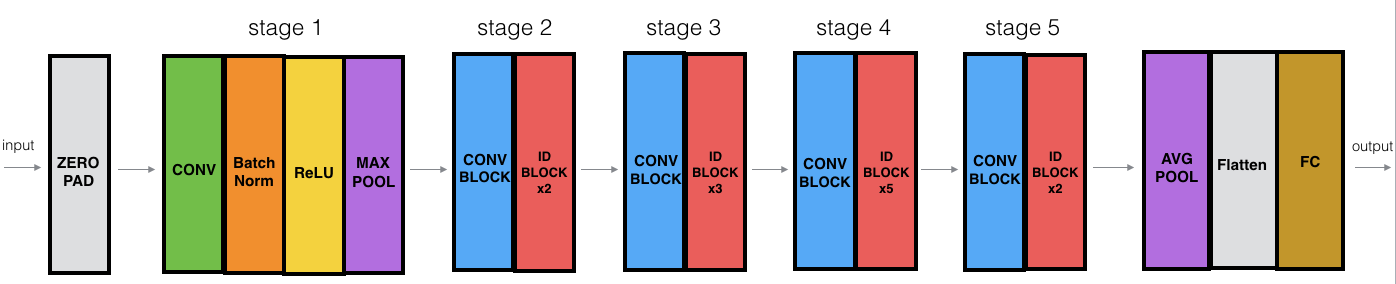

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). 
    - BatchNorm is applied to the 'channels' axis of the input.
    - ReLU activation is applied.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    - The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    - The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
- The 2D Average Pooling uses a window of shape (2,2).
- The 'flatten' layer doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

<b> Exercise 3 - ResNet50 </b> 
    
Implement the ResNet with 50 layers described in the figure above. We have implemented Stages 1 and 2. Please implement the rest. (The syntax for implementing Stages 3-5 should be quite similar to that of Stage 2) Make sure you follow the naming convention in the text above. 

You'll need to use this function: 
- Average pooling [see reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D)

Here are some other functions we used in the code below:
- Conv2D: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
- BatchNorm: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) (axis: Integer, the axis that should be normalized (typically the features axis))
- Zero padding: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ZeroPadding2D)
- Max pooling: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)
- Fully connected layer: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
- Addition: [See reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add)

In [ ]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ### START CODE HERE
    
    ## Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    
    ## Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    ## Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2,2))(X)
    
    ### END CODE HERE

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

Run the following code to build the model's graph. If your implementation is not correct you will know it by checking your accuracy when running model.fit(...) below.

In [ ]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)

As seen in the Keras Tutorial Notebook, prior training a model, you need to configure the learning process by compiling the model.

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

The model is now ready to be trained. The only thing you need is a dataset.

Let's load the SIGNS Dataset.

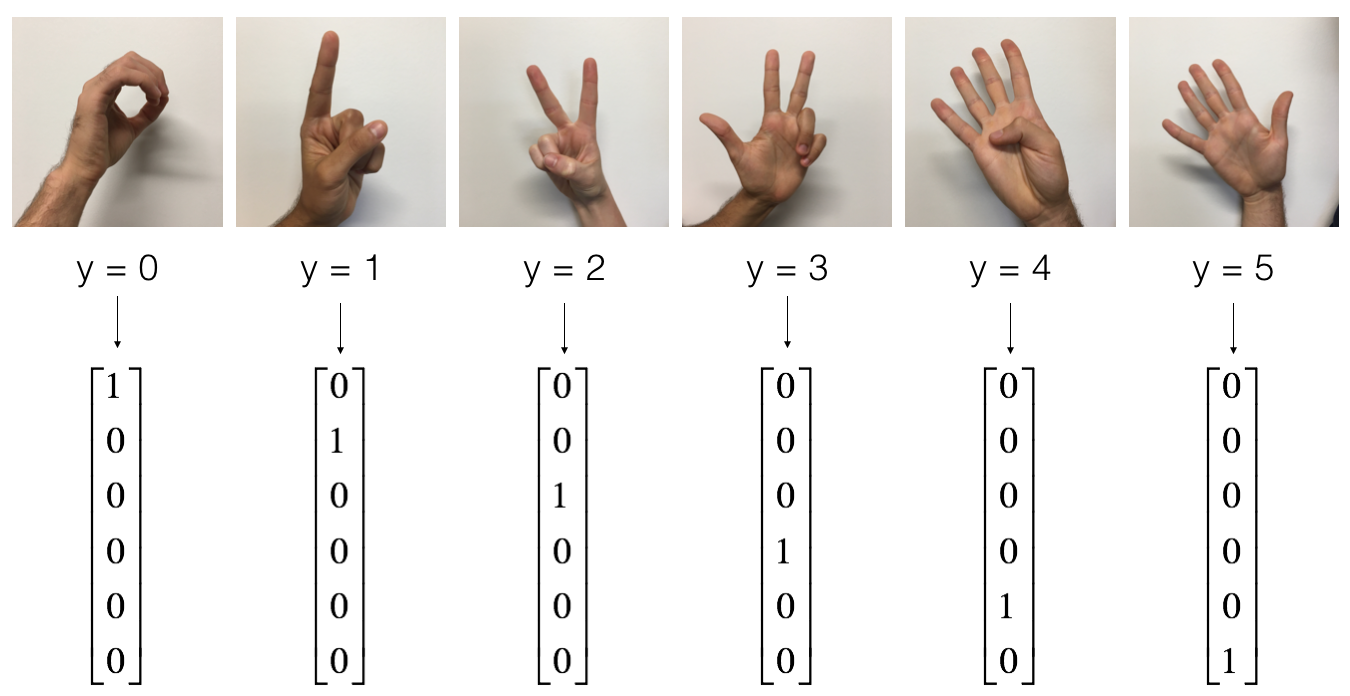

In [ ]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080

number of test examples = 120

X_train shape: (1080, 64, 64, 3)

Y_train shape: (1080, 6)

X_test shape: (120, 64, 64, 3)

Y_test shape: (120, 6)

Run the following cell to train your model on 2 epochs with a batch size of 32. On a CPU it should take you around 5min per epoch.

In [ ]:
model.fit(X_train, Y_train, epochs = 2, batch_size = 32)

Epoch 1/2
1080/1080 [==============================] - 239s - loss: 3.1942 - acc: 0.2491   
Epoch 2/2
1080/1080 [==============================] - 239s - loss: 2.1673 - acc: 0.3639   
<keras.callbacks.History at 0x7f2a65b8d898>

<b> Expected Output: </b>

** Epoch 1/2** : loss: between 1 and 5, acc: between 0.2 and 0.5, although your results can be different from ours.

** Epoch 2/2** : loss: between 1 and 5, acc: between 0.2 and 0.5, you should see your loss decreasing and the accuracy increasing.
	



Let's see how this model (trained on only two epochs) performs on the test set.

In [ ]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 10s 

Loss = 2.51410107613

Test Accuracy = 0.166666666667

<b>Expected Output:</b>

** Test Accuracy ** : between 0.16 and 0.25

For the purpose of this assignment, we've asked you to train the model only for two epochs. You can see that it achieves poor performances. Please go ahead and submit your assignment; to check correctness, the online grader will run your code only for a small number of epochs as well.

After you have finished this official (graded) part of this assignment, you can also optionally train the ResNet for more iterations, if you want. We get a lot better performance when we train for ~20 epochs, but this will take more than an hour when training on a CPU.

Using a GPU, we've trained our own ResNet50 model's weights on the SIGNS dataset. You can load and run our trained model on the test set in the cells below. It may take ≈1min to load the model.



In [ ]:
model = load_model('ResNet50.h5') 

In [ ]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 9s

Loss = 0.530178320408

Test Accuracy = 0.866666662693

ResNet50 is a powerful model for image classification when it is trained for an adequate number of iterations. We hope you can use what you've learnt and apply it to your own classification problem to perform state-of-the-art accuracy.

Congratulations on finishing this assignment! You've now implemented a state-of-the-art image classification system!


